# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up graphlab create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [21]:
sales = graphlab.SFrame('kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [37]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [38]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [39]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 0.303058     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 0.328093     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 0.359155     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 0.387787     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 0.413797     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 0.440041     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [78]:
model_all.get("coefficients").print_rows(num_rows=len(all_features)+2)
model_all["coefficients"]["value"].nnz()

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None |  274873.05595 |  None  |
|     bedrooms     |  None |      0.0      |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 8468.53108691 |  None  |
|   sqft_living    |  None | 24.4207209824 |  None  |
| sqft_living_sqrt |  None | 350.060553386 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 842.068034898 |  None  |
|    sqft_above    |  None | 20.0247224171 |  None  |
|  sqft_basement   |  None |

6

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [41]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

L1 Penalty		RSS
10		625766285142460
31		625766285362394
100		625766286057885
316		625766288257224
1000		625766295212186
3162		625766317206081
10000		625766386760658
31622		625766606749278
100000		625767302791635
316227		625769507643886
1000000		625776517727024
3162277		625799062845467
10000000		625883719085425
10.0 6.25766285142e+14


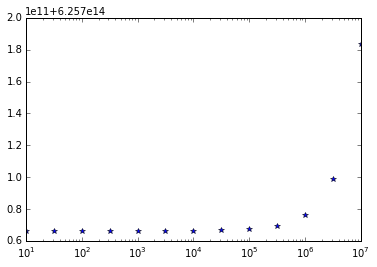

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_residual_sum_of_squares(model, data, outcome):
    # First get the predictions
    pred = model.predict(data)
    # Then compute the residuals/errors
    res =  pred - outcome
    # Then square and add them up
    RSS =  (res * res).sum() #np.dot(res,res).sum()
    return(RSS)

print "L1 Penalty\t\tRSS"
x = []
y = []
minrss = 1e40
minpenalty = 0

for l1p in np.logspace(1, 7, num=13):
    mdl = graphlab.linear_regression.create(training, target='price', features=all_features,
                                     validation_set=None, l2_penalty=0., 
                                     l1_penalty=l1p, verbose= False)
    rssval = get_residual_sum_of_squares(mdl,validation,validation['price'])
    
    print "%d\t\t%0.0f" % (l1p, rssval)
    x.append(l1p)
    y.append(rssval)
    if rssval < minrss:
        minrss = rssval
        minpenalty = l1p
    
print minpenalty, minrss
plt.plot(x,y,'*')
plt.xscale('log')    



*** QUIZ QUESTIONS ***
1. What was the best value for the `l1_penalty`?
2. What is the RSS on TEST data of the model with the best `l1_penalty`?

In [58]:
mdlbest = graphlab.linear_regression.create(training, target='price', features=all_features,
                                     validation_set=None, l2_penalty=0, 
                                     l1_penalty=10, verbose= False)
rsstest = get_residual_sum_of_squares(mdl,testing,testing['price'])
print rsstest

1.56972779669e+14


***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [64]:
mdlbest.get("coefficients").print_rows(num_rows=len(all_features)+2)
mdlbest["coefficients"]["value"].nnz()


+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4272128   |  None  |
|     bedrooms     |  None |  7936.96767903   |  None  |
| bedrooms_square  |  None |  936.993368193   |  None  |
|    bathrooms     |  None |  25409.5889341   |  None  |
|   sqft_living    |  None |  39.1151363797   |  None  |
| sqft_living_sqrt |  None |  1124.65021281   |  None  |
|     sqft_lot     |  None | 0.00348361822299 |  None  |
|  sqft_lot_sqrt   |  None |  148.258391011   |  None  |
|      floors      |  None |   21204.335467   |  None  |
|  floors_square   |  None |  12915.5243361   |  None  |
|    waterfront    |  None |  601905.594545   |  None  |
|       view       |  None |  93312.8573119   |  None  |
|    condition     |  None |  6609.03571245   |  None  |
|      grade       |  None |  6206.93999188   |  None  |
|    sqft_above    |  None |  4

18

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [60]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [61]:
l1_penalty_values = np.logspace(8, 10, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [66]:
print "L1 Penalty\t\tRSS"
x = []
y = []
maxnz = 30
minnz = 0

maxpen = 0
minpen = 0


for l1p in l1_penalty_values:
    mdl = graphlab.linear_regression.create(training, target='price', features=all_features,
                                     validation_set=None, l2_penalty=0, 
                                     l1_penalty=l1p, verbose= False)
    #rssval = get_residual_sum_of_squares(mdl,validation,validation['price'])
    nnz = mdl["coefficients"]["value"].nnz()
    print "%d\t\t%0.0f" % (l1p, nnz)
    # x.append(l1p)
    #y.append(rssval)
    if nnz < maxnz and nnz > max_nonzeros:
        maxnz = nnz
        maxpen = l1p
        
    if nnz > minnz and nnz < max_nonzeros:
        minnz = nnz 
        minpen = l1p
        
    
print maxpen, maxnz
print minpen, minnz
# plt.plot(x,y,'*')
# plt.xscale('log')    



L1 Penalty		RSS
100000000		18
127427498		18
162377673		18
206913808		18
263665089		17
335981828		17
428133239		17
545559478		17
695192796		17
885866790		16
1128837891		15
1438449888		15
1832980710		13
2335721469		12
2976351441		10
3792690190		6
4832930238		5
6158482110		3
7847599703		1
10000000000		1
2976351441.63 10
3792690190.73 6


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [79]:
l1_penalty_min = 2976351441.63
l1_penalty_max = 3792690190

***QUIZ QUESTIONS***

What values did you find for `l1_penalty_min` and`l1_penalty_max`? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [80]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzero`.

L1 Penalty		RSS
2976351442		966925692362085		10
3019316639		974019450084555		10
3062281836		981188367942454		10
3105247033		989328342459474		10
3148212231		998783211265890		10
3191177428		1008477167020094		10
3234142625		1018298780553819		10
3277107823		1028247992205977		10
3320073020		1034616909232827		8
3363038217		1038554735941040		8
3406003414		1043237237871701		8
3448968612		1046937488751712		7
3491933809		1051147625612862		7
3534899006		1055992735342999		7
3577864204		1060799531763287		7
3620829401		1065707689498230		6
3663794598		1069464335425585		6
3706759795		1073504549585599		6
3749724993		1077632775581415		6
3792690190		1081867592324112		6
2976351441.63 9.66925692362e+14


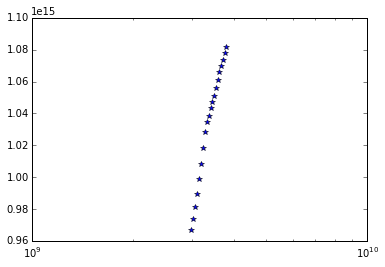

In [87]:
print "L1 Penalty\t\tRSS"
x = []
y = []
minrss = 1e40
minpenalty = 0
z = []

for l1p in l1_penalty_values:
    mdl = graphlab.linear_regression.create(training, target='price', features=all_features,
                                     validation_set=None, l2_penalty=0, 
                                     l1_penalty=l1p, verbose= False)
    rssval = get_residual_sum_of_squares(mdl,validation,validation['price'])
    nnz = mdl["coefficients"]["value"].nnz()
    
    print "%0.0f\t\t%0.0f\t\t%d" % (l1p, rssval, nnz)
    x.append(l1p)
    y.append(rssval)
    z.append(nnz)
    if rssval < minrss:
        minrss = rssval
        minpenalty = l1p
    
print minpenalty, minrss
plt.plot(x,y,'*')
plt.xscale('log')    

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [88]:
mdl = graphlab.linear_regression.create(training, target='price', features=all_features,
                                     validation_set=None, l2_penalty=0, 
                                     l1_penalty=3448968612, verbose= False)

In [89]:
mdl.get("coefficients").print_rows(num_rows=len(all_features)+2)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 222253.192544 |  None  |
|     bedrooms     |  None | 661.722717782 |  None  |
| bedrooms_square  |  None |      0.0      |  None  |
|    bathrooms     |  None | 15873.9572593 |  None  |
|   sqft_living    |  None | 32.4102214513 |  None  |
| sqft_living_sqrt |  None | 690.114773313 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |      0.0      |  None  |
|  floors_square   |  None |      0.0      |  None  |
|    waterfront    |  None |      0.0      |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None |      0.0      |  None  |
|      grade       |  None | 2899.42026975 |  None  |
|    sqft_above    |  None | 30.0115753022 |  None  |
|  sqft_basement   |  None |